In [96]:
import os
import math
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

## Анализ и предобработка

Проанализируем, что представляют из себя данные для обучения и тестирования модели.

In [2]:
train_df = pd.read_csv('/kaggle/input/silero-stress-predictor/train.csv')
train_df.head()

,id,word,stress,num_syllables,lemma
0,0,румяной,2,3,румяный
1,1,цифрами,1,3,цифра
2,2,слугами,1,3,слуга
3,3,выбирает,3,4,выбирать
4,4,управдом,3,3,управдом


In [3]:
train_df['stress'].unique()

array([2, 1, 3, 4, 5, 6])

In [4]:
test_df = pd.read_csv('/kaggle/input/silero-stress-predictor/test.csv')
test_df.head()

,id,word,num_syllables,lemma
0,0,эпилепсия,5,эпилепсия
1,1,относящейся,5,относиться
2,2,размышлениями,6,размышление
3,3,модемы,3,модем
4,4,солнц,1,солнце


Выборки отличаются колонкой 'stress', которая служит нашим таргетом и представляет из себя слог от 1 до 6, куда может быть поставлено ударение в слове.

Перед тем, как начать работать с данными, проведём анализ данных. Из условия задания нам известно, что не все ударения в датасете являются правильными (специально внесен некоторый шум). Поэтому также проверим наши данные на пропуски и крайние случаи.

In [5]:
train_df.isna().sum()

id               0
word             0
stress           0
num_syllables    0
lemma            0
dtype: int64

Прекрасно, пропусков нет.

Рассмотрим следующие крайние случаи:
1. количество слогов `num_syllables` не соответствует действительному (количеству гласных в слове)
2. ударение указывает на слог, которого нет в слове

In [6]:
vowels = 'аеёиоуыэюя'

def count_vowels(word):
    count = 0
    for char in word:
        if char.lower() in vowels:
            count += 1
    return count


train_df['num_vowels'] = train_df['word'].apply(count_vowels)
test_df['num_vowels'] = test_df['word'].apply(count_vowels)

In [7]:
# 1.

bad_vowels_index = train_df[train_df['num_vowels'] != train_df['num_syllables']].index
print(f'Наблюдений в train, где указано неверное количество слогов: {len(bad_vowels_index)}')

bad_vowels_index = test_df[test_df['num_vowels'] != test_df['num_syllables']].index
print(f'Наблюдений в test, где указано неверное количество слогов: {len(bad_vowels_index)}')

Наблюдений в train, где указано неверное количество слогов: 0
Наблюдений в test, где указано неверное количество слогов: 0


Так как колонки `num_vowels` и `num_syllables` по своему смыслу, а различий не наблюдается, избавимся от варианта `num_vowels` за ненадобностью.

In [8]:
train_df.drop('num_vowels', axis=1, inplace=True)
test_df.drop('num_vowels', axis=1, inplace=True)

Второй крайний случай актуален только для обучающей выборки.

In [9]:
# 2.

bad_stress_index = train_df[train_df['stress'] > train_df['num_syllables']].index
print(f'Наблюдений в train, где указано неверное количество слогов: {len(bad_stress_index)}')

Наблюдений в train, где указано неверное количество слогов: 0


Это значит, что от шума в данных мы избавиться не можем, так как он полностью обусловен исключительно неправильной постановкой ударения.

Разделим обучающую выборку на обучающую и валидационную в пропорции 80 на 20, чтобы мы могли валидировать качество модели, прежде чем предсказывать его на тестовой выборке в соревновании. Делить будет по уникальным леммам, чтобы леммы в выборках не пересекались между собой и можно было лучше оценить обучаемость модели.

In [10]:
lemmas = train_df['lemma'].unique()

train_lemmas, val_lemmas = train_test_split(lemmas, test_size=0.2, random_state=1)

train_split = train_df[train_df['lemma'].isin(train_lemmas)].reset_index(drop=True)
val_split = train_df[train_df['lemma'].isin(val_lemmas)].reset_index(drop=True)

print(f"Train samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")

Train samples: 50468
Validation samples: 12970


In [11]:
train_lemmas = set(train_split['lemma'].unique())
val_lemmas = set(val_split['lemma'].unique())
test_lemmas = set(test_df['lemma'].unique())

print(f"Train lemmas: {len(train_lemmas)}")
print(f"Val lemmas: {len(val_lemmas)} (intersection with train: {len(train_lemmas & val_lemmas)})")
print(f"Test lemmas: {len(test_lemmas)} (intersection with train: {len(train_lemmas & test_lemmas)})")

Train lemmas: 18834
Val lemmas: 4709 (intersection with train: 0)
Test lemmas: 15306 (intersection with train: 6696)


## Загрузка и обработка данных

Создадим словарь индексов для символов, который потом будем использовать для кодирования слов. 

In [12]:
# перед созданием словаря проверяем, что у нас нет сюрпризов в виде заглавных букв

mask_train = train_split['word'].str[0].str.isupper()
mask_val = val_split['word'].str[0].str.isupper()
mask_test = test_df['word'].str[0].str.isupper()

uppercase_words_train = train_split[mask_train]
uppercase_words_val = val_split[mask_val]
uppercase_words_test = test_df[mask_test]

total = len(uppercase_words_train) + len(uppercase_words_val) + len(uppercase_words_test)

print(f"Слов, начинающихся с заглавной буквы: {total}")

Слов, начинающихся с заглавной буквы: 0


In [13]:
vowels = 'аеёиоуыэюя'
consonants = 'бвгджзйклмнпрстфхцчшщ'
special_chars = 'ьъ-'

alphabet = list(vowels + consonants + special_chars)
char2idx = {char: idx + 1 for idx, char in enumerate(sorted(alphabet))}

# добавляю на всякий случай, если вдруг в выборке могут встретиться ошибки в виде латинских буквы и т.п.
char2idx['<unk>'] = len(char2idx) + 1

print(char2idx)

{'-': 1, 'а': 2, 'б': 3, 'в': 4, 'г': 5, 'д': 6, 'е': 7, 'ж': 8, 'з': 9, 'и': 10, 'й': 11, 'к': 12, 'л': 13, 'м': 14, 'н': 15, 'о': 16, 'п': 17, 'р': 18, 'с': 19, 'т': 20, 'у': 21, 'ф': 22, 'х': 23, 'ц': 24, 'ч': 25, 'ш': 26, 'щ': 27, 'ъ': 28, 'ы': 29, 'ь': 30, 'э': 31, 'ю': 32, 'я': 33, 'ё': 34, '<unk>': 35}


Теперь создадим кастомный датасет на основе `torch.utils.data.Dataset` для подготовки входных данных и подачи их в `DataLoader`. Класс будет универсальным и работать как с обучающей, так и с тестовой выборкой.

Помимо исходных признаков в виде структуры слова также извлечём дополнительные признаки, которые, возможно, помогут модели показать более хорошее качество на незнакомых ей леммах. Для начала в качестве признака конкатинируем маску гласных, так как только над ними можно ставить ударение.

In [ ]:
VOWELS = set(vowels)      # для создания дополнительного признака с гласными буквами (так как ударение можно ставить только над ними)


class StressDataset(Dataset):
    def __init__(self, csv_path_or_df, char2idx, is_test=False):
        """
        csv_path_or_df: путь к .csv или готовый pandas DataFrame
        char2idx: вручную созданный словарь {символ: индекс}
        is_test: если True, то нет метки stress
        """
        if isinstance(csv_path_or_df, str):
            self.data = pd.read_csv(csv_path_or_df)
        elif isinstance(csv_path_or_df, pd.DataFrame):
            self.data = csv_path_or_df.copy()
        else:
            raise ValueError("csv_path_or_df должен быть либо строкой (путь к файлу), либо DataFrame")

        self.is_test = is_test
        self.char2idx = char2idx
        
    def __len__(self):
        return len(self.data)

    def encode_word(self, word):
        """
        Преобразует слово в список индексов, а также создаёт маску гласных
        """
        word_encoded = []      # индексы символов по словарю char2idx
        vowels_mask = []      # маска, показывает, где гласные

        for char in word:
            idx = self.char2idx.get(char, self.char2idx.get('<unk>'))   # ищем индекс символа
            word_encoded.append(idx)

            is_vowel = 1 if char in VOWELS else 0    # создаём маску гласных букв
            vowels_mask.append(is_vowel)

        return (
            torch.tensor(word_encoded, dtype=torch.long),     # индексы символов
            torch.tensor(vowels_mask, dtype=torch.float)    # маска гласных
        )

    def __getitem__(self, idx):
        """
        Возвращает один элемент из датасета по индексу idx датасета.
        В режиме обучения и валидации (is_test=False) возвращает кортеж вида ((word_tensor, vowel_mask), stress_label)
        В режиме тестирования (is_test=True) возвращает кортеж вида ((word_tensor, vowel_mask), item_id)
        """
        row = self.data.iloc[idx]
        word_tensor, vowel_mask = self.encode_word(row['word'])

        if self.is_test:
            item_id = row['id'] if 'id' in row else idx
            return (word_tensor, vowel_mask), item_id      # возвращаем с индексом слова, так как понадобится для формирования submission

        # Тренировочная часть с меткой stress
        # stress_label = torch.tensor(row['stress'] - 1, dtype=torch.long)
        stress_label = torch.tensor(row['stress'], dtype=torch.long)
        return (word_tensor, vowel_mask), stress_label


Также создадим функцию для обработки батча и работы с `DataLoader`.

In [15]:
def collate_fn(batch):
    word_tensors = []
    vowel_masks = []
    lengths = []
    targets_or_ids = []

    # определяем режим train/test, чтобы не задавать его явно
    target = batch[0][1]
    is_test = not torch.is_tensor(target)

    for (word_tensor, vowel_mask), target_or_id in batch:
        word_tensors.append(word_tensor)
        vowel_masks.append(vowel_mask)
        lengths.append(len(word_tensor))
        targets_or_ids.append(target_or_id)

    # паддим по самому длинному в батче слову
    padded_word_tensors = pad_sequence(word_tensors, batch_first=True, padding_value=0)
    padded_vowel_masks = pad_sequence(vowel_masks, batch_first=True, padding_value=0.0)
    # массив реальных длин слов до паддинга
    lengths = torch.tensor(lengths, dtype=torch.long)

    if is_test:
        batch_ids = [int(i) for i in targets_or_ids]
        return (padded_word_tensors, padded_vowel_masks, lengths), batch_ids
    else:
        stress_labels = torch.stack(targets_or_ids)
        return (padded_word_tensors, padded_vowel_masks, lengths), stress_labels


#### Теперь, когда у нас всё готово, подготовим данные перед обучением.

In [16]:
train_dataset = StressDataset(train_split, char2idx=char2idx, is_test=False)
val_dataset = StressDataset(val_split, char2idx=char2idx, is_test=False)
test_dataset = StressDataset('/kaggle/input/silero-stress-predictor/test.csv', char2idx=char2idx, is_test=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

vocab_size = len(train_dataset.char2idx)

# Модели и обучение

### CNN

Для начала попробуем простую свёрточную нейронную сеть, чтобы отладить обучение и оценить сложность задачи.

In [51]:
class StressConvNet_test(nn.Module):
    def __init__(self, vocab_size, dropout=0.3):
        super().__init__()

        self.embedding_dim = 64
        self.n_out_channels = 64


        self.embedding = nn.Embedding(
            num_embeddings = vocab_size + 1,  # +1 для паддинга
            embedding_dim = self.embedding_dim,
            padding_idx = 0
        )
        
        self.conv1d = nn.Conv1d(
            in_channels = self.embedding_dim + 1,  # +1 из-за маски гласных
            out_channels = self.n_out_channels,
            kernel_size = 3,
            padding = 1
        )
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(self.n_out_channels)
        
        self.fc = nn.Linear(self.n_out_channels, 1)

    
    def forward(self, inputs):
        padded_word_tensors, padded_vowel_masks, lengths = inputs
        
        x_embed = self.embedding(padded_word_tensors)   # [batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]
        vowel_mask_expanded = padded_vowel_masks.unsqueeze(-1)   # [batch_size, seq_len] -> [batch_size, seq_len, 1]
        x = torch.cat([x_embed, vowel_mask_expanded], dim=-1)   # -> [batch_size, seq_len, embedding_dim + 1]
        
        x = x.permute(0, 2, 1)   # -> [batch_size, embedding_dim + 1, seq_len]
        x = self.conv1d(x)   # -> [batch_size, channels, seq_len]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = x.permute(0, 2, 1)   # -> [batch_size, seq_len, channels]

        logits = self.fc(x).squeeze(-1)  # [batch_size, seq_len]
        
        logits_list = []
        for i in range(logits.size(0)):
            mask = padded_vowel_masks[i].bool()     # [seq_len,]
            logits_vowels_only = logits[i][mask]        # [num_vowels_in_word,]
            
            logits_list.append(logits_vowels_only)
        
        return logits_list


model = StressConvNet_test(vocab_size=vocab_size)

Создадим класс, который позволит нам провести обучение. Помимо очевидных функций реализуем также раннюю остановку для преотвращения переобучения, сохранение состояние модели с лучшим качеством на обучающей выборке для возможности дообучить модель с помощью resume=True (при этом состояние модели будет сохраняться, только если будет улучшаться качество метрики на валидационных данных), визуализацию метрики на train и val.

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device,
                 lr=1e-3, epochs=10, patience=3,
                 checkpoint_path='/kaggle/working/best_model.pt',
                 plot_path='/kaggle/working/training_plot.png',
                 resume=False):

        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.epochs = epochs
        self.patience = patience
        self.checkpoint_path = checkpoint_path
        self.plot_path = plot_path

        self.current_epoch = 0
        self.best_val_loss = float('inf')
        self.no_improvement_count = 0

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

        if resume:
            self.load_checkpoint()
        else:
            print(f"Starting fresh training with model {self.model.__class__.__name__}")

    def train(self):
        total_epochs = self.current_epoch + self.epochs

        print(f"Starting training at epoch {self.current_epoch + 1} out of {total_epochs}")

        for epoch in range(self.current_epoch + 1, total_epochs + 1):
            print(f"\nEpoch {epoch}/{total_epochs}")

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate_epoch()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

            if val_loss < self.best_val_loss:
                print(f"Validation loss improved: {self.best_val_loss:.4f} --> {val_loss:.4f}. Saving checkpoint.")
                self.best_val_loss = val_loss
                self.no_improvement_count = 0
                self.current_epoch = epoch
                self.save_checkpoint()
            else:
                self.no_improvement_count += 1
                print(f"No improvement for {self.no_improvement_count} epochs...")

            if self.no_improvement_count >= self.patience:
                print("\nEarly stopping triggered. Loading best checkpoint...")
                self.load_checkpoint()
                break

        print("\nTraining finished. Loading best model...")
        self.load_checkpoint()
        self.plot_training()

    def train_epoch(self):
        self.model.train()

        total_loss = 0
        total_correct = 0
        total_samples = 0

        for (padded_word_tensors, padded_vowel_masks, lengths), stress_labels in tqdm(self.train_loader, desc='Train'):
            padded_word_tensors = padded_word_tensors.to(self.device)
            padded_vowel_masks = padded_vowel_masks.to(self.device)
            lengths = lengths.to(self.device)
            stress_labels = stress_labels.to(self.device)

            logits_list = self.model((padded_word_tensors, padded_vowel_masks, lengths))

            losses = []
            correct_preds = 0

            for i in range(len(logits_list)):
                logits = logits_list[i]
                target = stress_labels[i] - 1      # 0-based индекс

                if logits.numel() == 0:
                    continue

                loss = F.cross_entropy(logits.unsqueeze(0), target.unsqueeze(0))
                losses.append(loss)

                pred = logits.argmax().item()
                if pred == target.item():
                    correct_preds += 1

            if len(losses) == 0:
                continue

            batch_loss = torch.stack(losses).mean()

            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()

            total_loss += batch_loss.item() * len(logits_list)
            total_correct += correct_preds
            total_samples += len(logits_list)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0

        return avg_loss, accuracy

    @torch.no_grad()
    def validate_epoch(self):
        self.model.eval()

        total_loss = 0
        total_correct = 0
        total_samples = 0

        for (padded_word_tensors, padded_vowel_masks, lengths), stress_labels in tqdm(self.val_loader, desc='Validate'):
            padded_word_tensors = padded_word_tensors.to(self.device)
            padded_vowel_masks = padded_vowel_masks.to(self.device)
            lengths = lengths.to(self.device)
            stress_labels = stress_labels.to(self.device)

            logits_list = self.model((padded_word_tensors, padded_vowel_masks, lengths))

            losses = []
            correct_preds = 0

            for i in range(len(logits_list)):
                logits = logits_list[i]
                target = stress_labels[i] - 1  # 0-based индекс гласной среди гласных

                if logits.numel() == 0:
                    continue

                loss = F.cross_entropy(logits.unsqueeze(0), target.unsqueeze(0))
                losses.append(loss)

                pred = logits.argmax().item()
                if pred == target.item():
                    correct_preds += 1

            if len(losses) == 0:
                continue

            batch_loss = torch.stack(losses).mean()

            total_loss += batch_loss.item() * len(logits_list)
            total_correct += correct_preds
            total_samples += len(logits_list)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0

        return avg_loss, accuracy

    def save_checkpoint(self):
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': self.current_epoch,
            'best_val_loss': self.best_val_loss,
            'no_improvement_count': self.no_improvement_count,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies
        }
        torch.save(checkpoint, self.checkpoint_path)
        print(f"Saved new best model to {self.checkpoint_path}")

    def load_checkpoint(self):
        if os.path.exists(self.checkpoint_path):
            try:
                checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                self.current_epoch = checkpoint.get('epoch', 0)
                self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                self.no_improvement_count = checkpoint.get('no_improvement_count', 0)
                self.train_losses = checkpoint.get('train_losses', [])
                self.val_losses = checkpoint.get('val_losses', [])
                self.val_accuracies = checkpoint.get('val_accuracies', [])

                print(f"Loaded checkpoint from {self.checkpoint_path}. Resuming from epoch {self.current_epoch + 1}.")
            except RuntimeError as e:
                print(f"Error loading checkpoint: {e}")
                print("Checkpoint not compatible with current model. Starting from scratch.")
                self.current_epoch = 0
        else:
            print(f"No checkpoint found at {self.checkpoint_path}")
            self.current_epoch = 0

    def plot_training(self):
        if not self.train_losses:
            print("No training data to plot.")
            return

        epochs_range = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_losses, label='Train Loss')
        plt.plot(epochs_range, self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss per Epoch')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.val_accuracies, label='Val Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Validation Accuracy per Epoch')

        plt.tight_layout()

        plt.savefig(self.plot_path)
        print(f"Training plots saved to {self.plot_path}")
        plt.show()



Попробуем обучить модель.

Starting fresh training with model StressConvNet_test
Starting training at epoch 1 out of 15

Epoch 1/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 103.62it/s]


Train Loss: 0.8829 | Train Acc: 61.13%
Val Loss:   0.8282 | Val Acc:   63.69%
Validation loss improved: inf --> 0.8282. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 2/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 103.26it/s]


Train Loss: 0.8172 | Train Acc: 64.49%
Val Loss:   0.8081 | Val Acc:   64.80%
Validation loss improved: 0.8282 --> 0.8081. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 3/15


Validate: 100%|██████████| 406/406 [00:04<00:00, 101.23it/s]


Train Loss: 0.7996 | Train Acc: 65.41%
Val Loss:   0.7907 | Val Acc:   65.41%
Validation loss improved: 0.8081 --> 0.7907. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 4/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 114.87it/s]


Train Loss: 0.7887 | Train Acc: 65.99%
Val Loss:   0.7928 | Val Acc:   65.22%
No improvement for 1 epochs...

Epoch 5/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 101.64it/s]


Train Loss: 0.7838 | Train Acc: 66.32%
Val Loss:   0.7829 | Val Acc:   66.17%
Validation loss improved: 0.7907 --> 0.7829. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 6/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 104.22it/s]


Train Loss: 0.7767 | Train Acc: 66.56%
Val Loss:   0.7784 | Val Acc:   66.49%
Validation loss improved: 0.7829 --> 0.7784. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 7/15


Validate: 100%|██████████| 406/406 [00:04<00:00, 98.11it/s] 


Train Loss: 0.7734 | Train Acc: 67.12%
Val Loss:   0.7745 | Val Acc:   66.92%
Validation loss improved: 0.7784 --> 0.7745. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 8/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 103.34it/s]


Train Loss: 0.7685 | Train Acc: 67.01%
Val Loss:   0.7735 | Val Acc:   66.83%
Validation loss improved: 0.7745 --> 0.7735. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 9/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 102.87it/s]


Train Loss: 0.7668 | Train Acc: 67.23%
Val Loss:   0.7677 | Val Acc:   67.14%
Validation loss improved: 0.7735 --> 0.7677. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 10/15


Validate: 100%|██████████| 406/406 [00:04<00:00, 100.93it/s]


Train Loss: 0.7626 | Train Acc: 67.27%
Val Loss:   0.7646 | Val Acc:   66.93%
Validation loss improved: 0.7677 --> 0.7646. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 11/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 106.18it/s]


Train Loss: 0.7639 | Train Acc: 67.24%
Val Loss:   0.7690 | Val Acc:   66.39%
No improvement for 1 epochs...

Epoch 12/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 102.05it/s]


Train Loss: 0.7586 | Train Acc: 67.79%
Val Loss:   0.7699 | Val Acc:   66.44%
No improvement for 2 epochs...

Epoch 13/15


Validate: 100%|██████████| 406/406 [00:03<00:00, 102.33it/s]
<ipython-input-52-68e0317e3f15>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Train Loss: 0.7576 | Train Acc: 67.56%
Val Loss:   0.7664 | Val Acc:   66.88%
No improvement for 3 epochs...

Early stopping triggered. Loading best checkpoint...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 11.

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 11.
Training plots saved to /kaggle/working/training_plot.png


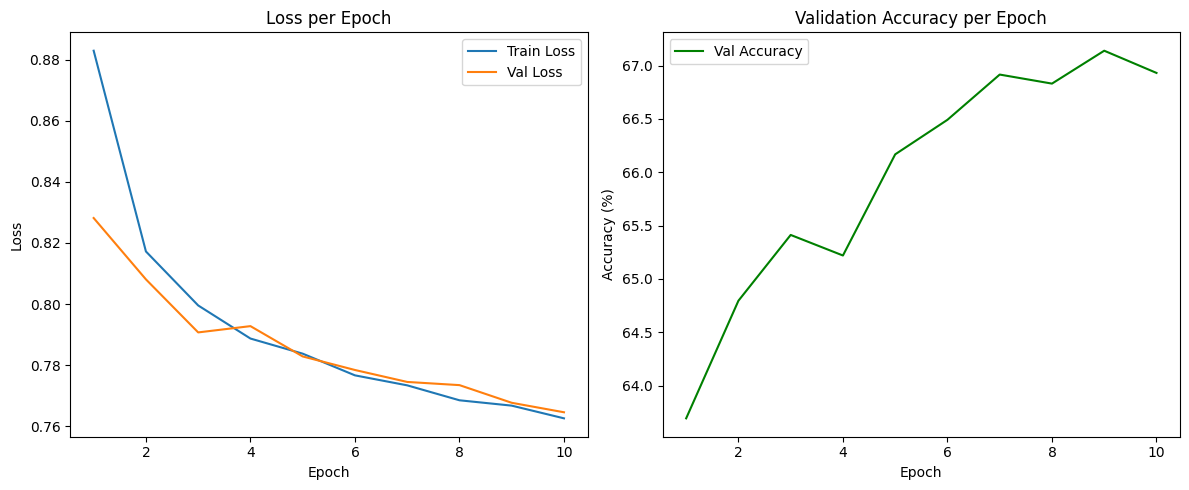

In [53]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=15,
    patience=3,
    checkpoint_path='best_stress_model.pt'
)

trainer.train()

Прекрасно, здесь даже видно, что у нас работает ранняя остановка. Всё работает, теперь можно попробовать немного усложнить модель.

In [17]:
class StressConvNet(nn.Module):
    def __init__(self, vocab_size, dropout=0.3):
        super().__init__()

        self.embedding_dim = 64
        self.n_out_channels = 64


        self.embedding = nn.Embedding(
            num_embeddings = vocab_size + 1,  # +1 для паддинга
            embedding_dim = self.embedding_dim,
            padding_idx = 0
        )

        self.conv1_block = nn.Sequential(
            nn.Conv1d(self.embedding_dim + 1, self.n_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.n_out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.conv2_block = nn.Sequential(
            nn.Conv1d(self.n_out_channels, self.n_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.n_out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.conv3_block = nn.Sequential(
            nn.Conv1d(self.n_out_channels, self.n_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.n_out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.fc = nn.Linear(self.n_out_channels, 1)

    
    def forward(self, inputs):
        padded_word_tensors, padded_vowel_masks, lengths = inputs
        
        x_embed = self.embedding(padded_word_tensors)   # [batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]
        vowel_mask_expanded = padded_vowel_masks.unsqueeze(-1)   # [batch_size, seq_len] -> [batch_size, seq_len, 1]
        x = torch.cat([x_embed, vowel_mask_expanded], dim=-1)   # -> [batch_size, seq_len, embedding_dim + 1]
        
        x = x.permute(0, 2, 1)   # -> [batch_size, embedding_dim + 1, seq_len]
        x = self.conv1_block(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        
        x = x.permute(0, 2, 1)   # -> [batch_size, seq_len, conv_filters]
        
        logits_list = []
        for i in range(x.size(0)):
            mask = padded_vowel_masks[i].bool()   # [seq_len,]
            x_vowels_only = x[i][mask]   # -> [num_vowels_in_word, channels]

            logits_vowels = self.fc(x_vowels_only)
            logits_vowels = logits_vowels.squeeze(-1)   # -> [num_vowels_in_word,]
            logits_list.append(logits_vowels)

        return logits_list


model = StressConvNet(vocab_size=vocab_size)

Starting fresh training with model StressConvNetVowelFocused
Starting training at epoch 1 out of 15

Epoch 1/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 80.46it/s]


Train Loss: 0.7648 | Train Acc: 67.77%
Val Loss:   0.6628 | Val Acc:   73.47%
Validation loss improved: inf --> 0.6628. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 2/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 80.54it/s]


Train Loss: 0.6663 | Train Acc: 72.81%
Val Loss:   0.6175 | Val Acc:   75.44%
Validation loss improved: 0.6628 --> 0.6175. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 3/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 77.56it/s]


Train Loss: 0.6296 | Train Acc: 74.15%
Val Loss:   0.6004 | Val Acc:   75.48%
Validation loss improved: 0.6175 --> 0.6004. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 4/15


Validate: 100%|██████████| 406/406 [00:04<00:00, 86.70it/s]


Train Loss: 0.6055 | Train Acc: 75.34%
Val Loss:   0.5848 | Val Acc:   76.27%
Validation loss improved: 0.6004 --> 0.5848. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 5/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 76.65it/s]


Train Loss: 0.5916 | Train Acc: 75.88%
Val Loss:   0.5710 | Val Acc:   77.02%
Validation loss improved: 0.5848 --> 0.5710. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 6/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.73it/s]


Train Loss: 0.5770 | Train Acc: 76.56%
Val Loss:   0.5760 | Val Acc:   77.19%
No improvement for 1 epochs...

Epoch 7/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.20it/s]


Train Loss: 0.5652 | Train Acc: 77.04%
Val Loss:   0.5624 | Val Acc:   77.53%
Validation loss improved: 0.5710 --> 0.5624. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 8/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.80it/s]


Train Loss: 0.5600 | Train Acc: 77.18%
Val Loss:   0.5605 | Val Acc:   77.41%
Validation loss improved: 0.5624 --> 0.5605. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 9/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.86it/s]


Train Loss: 0.5489 | Train Acc: 77.66%
Val Loss:   0.5546 | Val Acc:   77.39%
Validation loss improved: 0.5605 --> 0.5546. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 10/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 80.92it/s]


Train Loss: 0.5432 | Train Acc: 77.93%
Val Loss:   0.5499 | Val Acc:   77.66%
Validation loss improved: 0.5546 --> 0.5499. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 11/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.46it/s]


Train Loss: 0.5387 | Train Acc: 78.19%
Val Loss:   0.5380 | Val Acc:   77.85%
Validation loss improved: 0.5499 --> 0.5380. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 12/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.86it/s]


Train Loss: 0.5314 | Train Acc: 78.59%
Val Loss:   0.5439 | Val Acc:   78.25%
No improvement for 1 epochs...

Epoch 13/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 79.17it/s]


Train Loss: 0.5298 | Train Acc: 78.42%
Val Loss:   0.5354 | Val Acc:   78.54%
Validation loss improved: 0.5380 --> 0.5354. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 14/15


Validate: 100%|██████████| 406/406 [00:04<00:00, 81.34it/s]


Train Loss: 0.5253 | Train Acc: 78.80%
Val Loss:   0.5343 | Val Acc:   78.49%
Validation loss improved: 0.5354 --> 0.5343. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 15/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 80.76it/s]
<ipython-input-20-f4c988d580d9>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.c

Train Loss: 0.5210 | Train Acc: 78.94%
Val Loss:   0.5322 | Val Acc:   78.87%
Validation loss improved: 0.5343 --> 0.5322. Saving checkpoint.
Saved new best model to best_stress_model.pt

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 16.
Training plots saved to /kaggle/working/training_plot.png


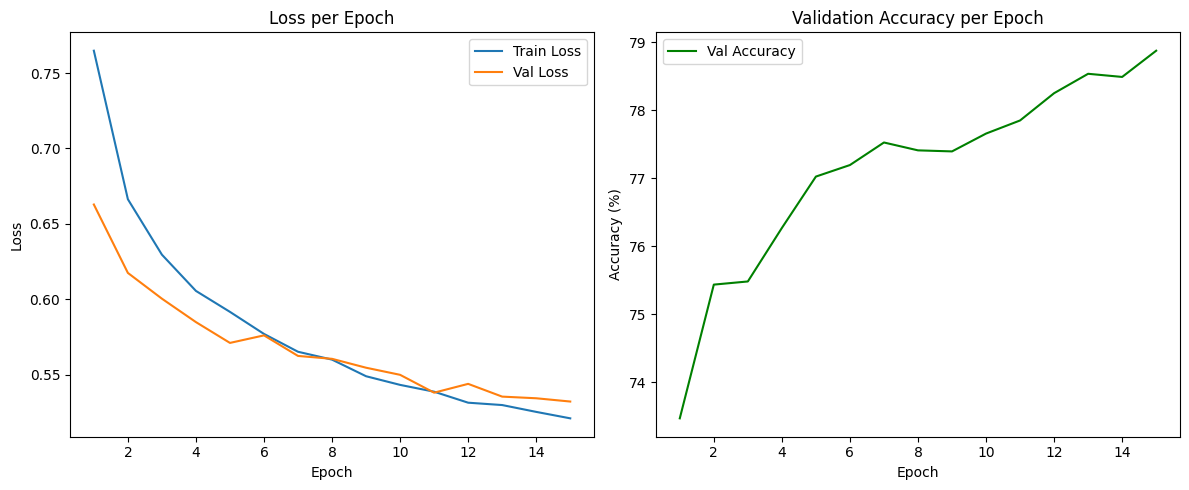

In [21]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=15,
    patience=3,
    checkpoint_path='best_stress_model.pt'
)

trainer.train()

Нейронные сети часто могут грешить overconfidence, поэтому (на всякий случай) проверим нашу модель с помощью калибровочной кривой. Строить кривую будем на валидационной выборке, чтобы оценить, насколько модель на самом деле пере- или недоуверена в своих ответах.

In [ ]:
def validate_with_calibration(trainer, val_loader):
    trainer.model.eval()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_confidences = []
    all_corrects = []

    with torch.no_grad():
        for (padded_word_tensors, padded_vowel_masks, lengths), stress_labels in tqdm(val_loader, desc='Validate'):
            padded_word_tensors = padded_word_tensors.to(trainer.device)
            padded_vowel_masks = padded_vowel_masks.to(trainer.device)
            lengths = lengths.to(trainer.device)
            stress_labels = stress_labels.to(trainer.device)

            logits_list = trainer.model((padded_word_tensors, padded_vowel_masks, lengths))

            losses = []
            correct_preds = 0

            for i in range(len(logits_list)):
                logits = logits_list[i]
                target = stress_labels[i] - 1

                if logits.numel() == 0:
                    continue

                loss = F.cross_entropy(logits.unsqueeze(0), target.unsqueeze(0))
                losses.append(loss)
                probs = F.softmax(logits, dim=0)
                
                max_prob, pred_idx = torch.max(probs, dim=0)
                correct = (pred_idx.item() == target.item())

                all_confidences.append(max_prob.item())
                all_corrects.append(int(correct))

                if correct:
                    correct_preds += 1

            if len(losses) == 0:
                continue

            batch_loss = torch.stack(losses).mean()

            total_loss += batch_loss.item() * len(logits_list)
            total_correct += correct_preds
            total_samples += len(logits_list)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0

    print(f"Val Loss: {avg_loss:.4f} | Val Acc: {accuracy:.2f}%")

    return all_confidences, all_corrects

Validate: 100%|██████████| 406/406 [00:05<00:00, 74.25it/s]


Val Loss: 0.5322 | Val Acc: 78.87%


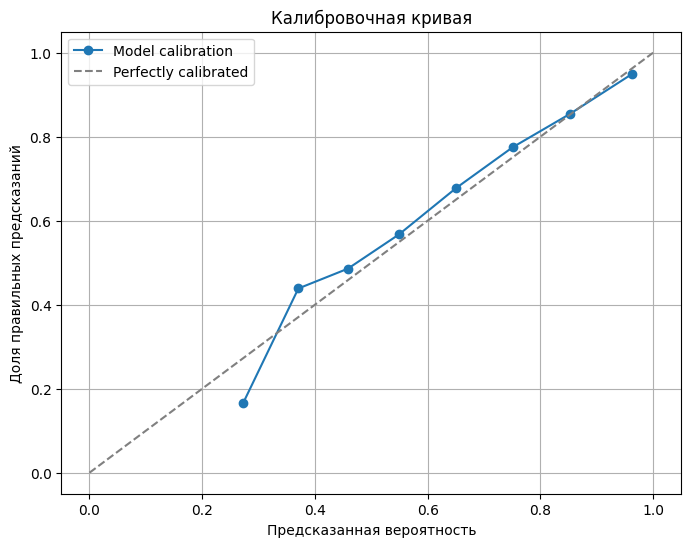

In [26]:
# прогоняем валидацию и собираем данные
confidences, corrects = validate_with_calibration(trainer, val_loader)

prob_true, prob_pred = calibration_curve(corrects, confidences, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля правильных предсказаний')
plt.title('Калибровочная кривая')
plt.legend()
plt.grid(True)
plt.show()

Поведение нашей модели близко к идеальному, это радует. 

### RNN(LSTM)

Мы использовали обычную CNN,а теперь попробуем использовать рекурентную нейронную сеть. Возможно, ей лучше удастся уловить зависимости, которые не видны нашей StressConvNet?

In [ ]:
class StressLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size + 1,
            embedding_dim=embedding_dim,
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim + 1,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, inputs):
        padded_word_tensors, padded_vowel_masks, lengths = inputs

        x_embed = self.embedding(padded_word_tensors)
        vowel_mask_expanded = padded_vowel_masks.unsqueeze(-1)
        x = torch.cat([x_embed, vowel_mask_expanded], dim=-1)

        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        output = self.dropout(output)

        logits_list = []
        for i in range(output.size(0)):
            mask = padded_vowel_masks[i].bool()
            output_vowels_only = output[i][mask]

            logits_vowels = self.fc(output_vowels_only).squeeze(-1)
            logits_list.append(logits_vowels)

        return logits_list


model = StressLSTM(vocab_size=vocab_size)

Starting fresh training with model StressLSTM
Starting training at epoch 1 out of 15

Epoch 1/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.38it/s]


Train Loss: 0.6528 | Train Acc: 72.82%
Val Loss:   0.5966 | Val Acc:   75.57%
Validation loss improved: inf --> 0.5966. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 2/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 74.11it/s]


Train Loss: 0.5054 | Train Acc: 79.19%
Val Loss:   0.5586 | Val Acc:   77.79%
Validation loss improved: 0.5966 --> 0.5586. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 3/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 74.57it/s]


Train Loss: 0.4321 | Train Acc: 82.63%
Val Loss:   0.5126 | Val Acc:   79.28%
Validation loss improved: 0.5586 --> 0.5126. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 4/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.89it/s]


Train Loss: 0.3690 | Train Acc: 85.32%
Val Loss:   0.5223 | Val Acc:   80.08%
No improvement for 1 epochs...

Epoch 5/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 74.71it/s]


Train Loss: 0.3189 | Train Acc: 87.55%
Val Loss:   0.5127 | Val Acc:   80.34%
No improvement for 2 epochs...

Epoch 6/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.21it/s]
<ipython-input-52-68e0317e3f15>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.c

Train Loss: 0.2770 | Train Acc: 89.34%
Val Loss:   0.5245 | Val Acc:   80.49%
No improvement for 3 epochs...

Early stopping triggered. Loading best checkpoint...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 4.

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 4.
Training plots saved to /kaggle/working/training_plot.png


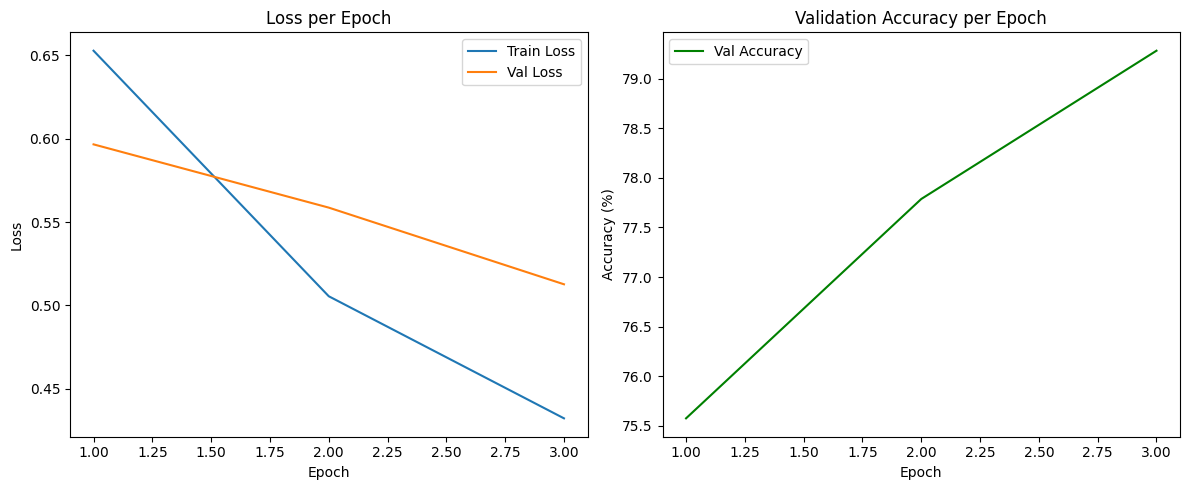

In [59]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=15,
    patience=3,
    checkpoint_path='best_stress_model.pt'
)

trainer.train()

Validate: 100%|██████████| 406/406 [00:05<00:00, 69.86it/s]


Val Loss: 0.5126 | Val Acc: 79.28%


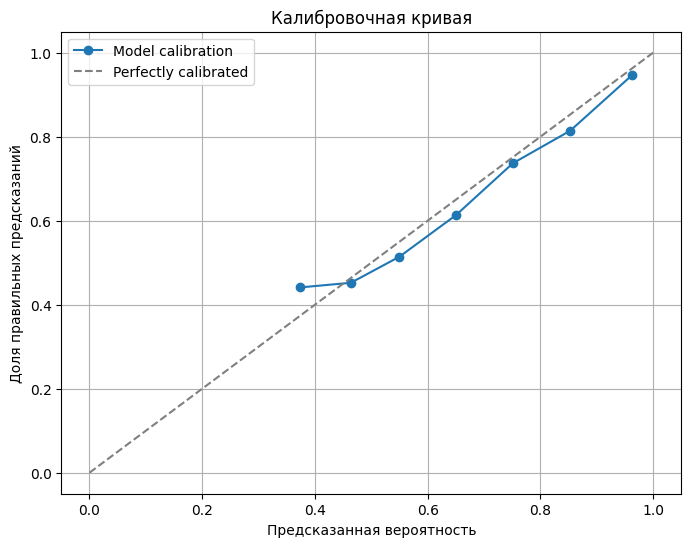

In [63]:
confidences, corrects = validate_with_calibration(trainer, val_loader)

prob_true, prob_pred = calibration_curve(corrects, confidences, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля правильных предсказаний')
plt.title('Калибровочная кривая')
plt.legend()
plt.grid(True)
plt.show()

Вывод: обчилась быстрее, на 3-й эпохе вышла на качество чуть выше StressConvNet (когда ей понадобилось 15 эпох), а дальше вышла на плато. LSTM посложнее, поэтому больше подвержена проблеме переуверенности, но в целом ненамного хуже StressConvNet в этом плане.

### Дополнительные признаки

А что, если попробовать добавить признаков модели, например, передать не только маску гласных, но и позицию символа в слове и позицию гласных среди гласных как дполнительные признаки? Для этого изменим уже имеющиеся класс `Dataset` и `collate_fn`. 

In [ ]:
class StressDataset(Dataset):
    def __init__(self, csv_path_or_df, char2idx, is_test=False):
        """
        csv_path_or_df: путь к .csv или готовый pandas DataFrame
        char2idx: вручную созданный словарь {символ: индекс}
        is_test: если True, то нет метки stress
        """
        if isinstance(csv_path_or_df, str):
            self.data = pd.read_csv(csv_path_or_df)
        elif isinstance(csv_path_or_df, pd.DataFrame):
            self.data = csv_path_or_df.copy()
        else:
            raise ValueError("csv_path_or_df должен быть либо строкой (путь к файлу), либо DataFrame")

        self.is_test = is_test
        self.char2idx = char2idx
        
    def __len__(self):
        return len(self.data)

    def encode_word(self, word):
        """
        Преобразует слово в список индексов, маску гласных,
        нормированные позиции символов и гласных.
        """
        word_encoded = []
        vowels_mask = []
        norm_char_pos = []
        norm_vowel_pos = []

        word_len = len(word)
        num_vowels = sum(1 for char in word if char in VOWELS)

        current_vowel_idx = 0

        for i, char in enumerate(word):
            idx = self.char2idx.get(char, self.char2idx.get('<unk>'))
            word_encoded.append(idx)

            # маска гласных
            is_vowel = 1 if char in VOWELS else 0
            vowels_mask.append(is_vowel)

            # нормированная позиция символа
            norm_char = i / (word_len - 1) if word_len > 1 else 0.0
            norm_char_pos.append(norm_char)

            # нормированная позиция гласной
            if is_vowel and num_vowels > 1:
                norm_vowel = current_vowel_idx / (num_vowels - 1)
                current_vowel_idx += 1
            elif is_vowel and num_vowels == 1:
                norm_vowel = 0.0
                current_vowel_idx += 1
            else:
                norm_vowel = -1.0

            norm_vowel_pos.append(norm_vowel)

        return (
            torch.tensor(word_encoded, dtype=torch.long),      
            torch.tensor(vowels_mask, dtype=torch.float),      
            torch.tensor(norm_char_pos, dtype=torch.float),    
            torch.tensor(norm_vowel_pos, dtype=torch.float)    
        )

    def __getitem__(self, idx):
        """
        Возвращает один элемент из датасета по индексу idx датасета.
        """
        row = self.data.iloc[idx]
        word_tensor, vowel_mask, norm_char_pos, norm_vowel_pos = self.encode_word(row['word'])

        if self.is_test:
            item_id = row['id'] if 'id' in row else idx
            return (word_tensor, vowel_mask, norm_char_pos, norm_vowel_pos), item_id

        stress_label = torch.tensor(row['stress'], dtype=torch.long)

        return (word_tensor, vowel_mask, norm_char_pos, norm_vowel_pos), stress_label

In [65]:
def collate_fn(batch):
    word_tensors = []
    vowel_masks = []
    norm_char_pos_list = []
    norm_vowel_pos_list = []
    lengths = []
    targets_or_ids = []

    target = batch[0][1]
    is_test = not torch.is_tensor(target)

    for (word_tensor, vowel_mask, norm_char_pos, norm_vowel_pos), target_or_id in batch:
        word_tensors.append(word_tensor)
        vowel_masks.append(vowel_mask)
        norm_char_pos_list.append(norm_char_pos)
        norm_vowel_pos_list.append(norm_vowel_pos)
        lengths.append(len(word_tensor))
        targets_or_ids.append(target_or_id)

    padded_word_tensors = pad_sequence(word_tensors, batch_first=True, padding_value=0)
    padded_vowel_masks = pad_sequence(vowel_masks, batch_first=True, padding_value=0.0)
    padded_norm_char_pos = pad_sequence(norm_char_pos_list, batch_first=True, padding_value=0.0)
    padded_norm_vowel_pos = pad_sequence(norm_vowel_pos_list, batch_first=True, padding_value=-1.0)

    lengths = torch.tensor(lengths, dtype=torch.long)

    if is_test:
        batch_ids = [int(i) for i in targets_or_ids]
        return (padded_word_tensors, padded_vowel_masks, lengths, padded_norm_char_pos, padded_norm_vowel_pos), batch_ids
    else:
        stress_labels = torch.stack(targets_or_ids)
        return (padded_word_tensors, padded_vowel_masks, lengths, padded_norm_char_pos, padded_norm_vowel_pos), stress_labels

In [66]:
train_dataset = StressDataset(train_split, char2idx=char2idx, is_test=False)
val_dataset = StressDataset(val_split, char2idx=char2idx, is_test=False)
test_dataset = StressDataset('/kaggle/input/silero-stress-predictor/test.csv', char2idx=char2idx, is_test=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

vocab_size = len(train_dataset.char2idx)

Теперь попробуем использовать модели на новых данных.

In [ ]:
class StressConvNet(nn.Module):
    def __init__(self, vocab_size, dropout=0.3):
        super().__init__()

        self.embedding_dim = 64
        self.n_out_channels = 64

        # +3: vowel_mask, norm_char_pos, norm_vowel_pos
        self.input_features_dim = self.embedding_dim + 3

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size + 1,  # +1 для паддинга
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )

        self.conv1_block = nn.Sequential(
            nn.Conv1d(self.input_features_dim, self.n_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.n_out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.conv2_block = nn.Sequential(
            nn.Conv1d(self.n_out_channels, self.n_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.n_out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.conv3_block = nn.Sequential(
            nn.Conv1d(self.n_out_channels, self.n_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.n_out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.fc = nn.Linear(self.n_out_channels, 1)

    def forward(self, inputs):
        padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos = inputs
        x_embed = self.embedding(padded_word_tensors)

        # Дополнительные признаки
        vowel_mask_expanded = padded_vowel_masks.unsqueeze(-1)
        norm_char_pos_expanded = norm_char_pos.unsqueeze(-1)
        norm_vowel_pos_expanded = norm_vowel_pos.unsqueeze(-1)

        x = torch.cat([x_embed, vowel_mask_expanded, norm_char_pos_expanded, norm_vowel_pos_expanded], dim=-1)     # -> [batch_size, seq_len, embedding_dim + 3]
        x = x.permute(0, 2, 1)  # -> [batch_size, channels, seq_len]

        x = self.conv1_block(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)

        x = x.permute(0, 2, 1)  # -> [batch_size, seq_len, conv_filters]

        logits_list = []
        for i in range(x.size(0)):
            mask = padded_vowel_masks[i].bool()
            x_vowels_only = x[i][mask]

            logits_vowels = self.fc(x_vowels_only)
            logits_vowels = logits_vowels.squeeze(-1)
            logits_list.append(logits_vowels)

        return logits_list

model = StressConvNet(vocab_size=vocab_size)

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device,
                 lr=1e-3, epochs=10, patience=3,
                 checkpoint_path='best_model.pt',
                 plot_path='training_plot.png',
                 optimizer=None, scheduler=None,
                 resume=False):
        
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = scheduler
            
        self.epochs = epochs
        self.patience = patience
        self.checkpoint_path = checkpoint_path
        self.plot_path = plot_path

        self.current_epoch = 0
        self.best_val_loss = float('inf')
        self.no_improvement_count = 0

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

        if resume:
            self.load_checkpoint()
        else:
            print(f"Starting fresh training with model {self.model.__class__.__name__}")

    def train(self):
        total_epochs = self.current_epoch + self.epochs
        print(f"Starting training at epoch {self.current_epoch + 1} out of {total_epochs}")

        for epoch in range(self.current_epoch + 1, total_epochs + 1):
            print(f"\nEpoch {epoch}/{total_epochs}")

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate_epoch()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

            if self.scheduler is not None:
                self.scheduler.step()

            if val_loss <= self.best_val_loss:
                print(f"Validation loss improved: {self.best_val_loss:.4f} --> {val_loss:.4f}. Saving checkpoint.")
                self.best_val_loss = val_loss
                self.no_improvement_count = 0
                self.current_epoch = epoch
                self.save_checkpoint()
            else:
                self.no_improvement_count += 1
                print(f"No improvement for {self.no_improvement_count} epochs...")

            if self.no_improvement_count >= self.patience:
                print("\nEarly stopping triggered. Loading best checkpoint...")
                self.load_checkpoint()
                break

        print("\nTraining finished. Loading best model...")
        self.load_checkpoint()
        self.plot_training()

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for (padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos), stress_labels in tqdm(self.train_loader, desc='Train'):

            padded_word_tensors = padded_word_tensors.to(self.device)
            padded_vowel_masks = padded_vowel_masks.to(self.device)
            lengths = lengths.to(self.device)
            norm_char_pos = norm_char_pos.to(self.device)
            norm_vowel_pos = norm_vowel_pos.to(self.device)
            stress_labels = stress_labels.to(self.device)

            logits_list = self.model((padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos))

            losses = []
            correct_preds = 0

            for i in range(len(logits_list)):
                logits = logits_list[i]
                target = stress_labels[i] - 1

                loss = F.cross_entropy(logits.unsqueeze(0), target.unsqueeze(0))
                losses.append(loss)

                pred = logits.argmax().item()
                if pred == target.item():
                    correct_preds += 1

            if len(losses) == 0:
                continue

            batch_loss = torch.stack(losses).mean()

            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()

            total_loss += batch_loss.item() * len(logits_list)
            total_correct += correct_preds
            total_samples += len(logits_list)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0
        return avg_loss, accuracy

    @torch.no_grad()
    def validate_epoch(self):
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for (padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos), stress_labels in tqdm(self.val_loader, desc='Validate'):
            padded_word_tensors = padded_word_tensors.to(self.device)
            padded_vowel_masks = padded_vowel_masks.to(self.device)
            lengths = lengths.to(self.device)
            norm_char_pos = norm_char_pos.to(self.device)
            norm_vowel_pos = norm_vowel_pos.to(self.device)
            stress_labels = stress_labels.to(self.device)

            logits_list = self.model((padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos))

            losses = []
            correct_preds = 0

            for i in range(len(logits_list)):
                logits = logits_list[i]
                target = stress_labels[i] - 1

                loss = F.cross_entropy(logits.unsqueeze(0), target.unsqueeze(0))
                losses.append(loss)

                pred = logits.argmax().item()
                if pred == target.item():
                    correct_preds += 1

            if len(losses) == 0:
                continue

            batch_loss = torch.stack(losses).mean()

            total_loss += batch_loss.item() * len(logits_list)
            total_correct += correct_preds
            total_samples += len(logits_list)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0
        return avg_loss, accuracy

    def save_checkpoint(self):
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': self.current_epoch,
            'best_val_loss': self.best_val_loss,
            'no_improvement_count': self.no_improvement_count,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies
        }
        torch.save(checkpoint, self.checkpoint_path)
        print(f"Saved new best model to {self.checkpoint_path}")

    def load_checkpoint(self):
        if os.path.exists(self.checkpoint_path):
            try:
                checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                self.current_epoch = checkpoint.get('epoch', 0)
                self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                self.no_improvement_count = checkpoint.get('no_improvement_count', 0)
                self.train_losses = checkpoint.get('train_losses', [])
                self.val_losses = checkpoint.get('val_losses', [])
                self.val_accuracies = checkpoint.get('val_accuracies', [])

                print(f"Loaded checkpoint from {self.checkpoint_path}. Resuming from epoch {self.current_epoch + 1}.")
            except RuntimeError as e:
                print(f"Error loading checkpoint: {e}")
                print("Checkpoint not compatible with current model. Starting from scratch.")
                self.current_epoch = 0
        else:
            print(f"No checkpoint found at {self.checkpoint_path}")
            self.current_epoch = 0

    def plot_training(self):
        if not self.train_losses:
            print("No training data to plot.")
            return
        
        epochs_range = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_losses, label='Train Loss')
        plt.plot(epochs_range, self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss per Epoch')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.val_accuracies, label='Val Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Validation Accuracy per Epoch')

        plt.tight_layout()
        plt.savefig(self.plot_path)
        print(f"Training plots saved to {self.plot_path}")
        plt.show()


Starting fresh training with model StressConvNet
Starting training at epoch 1 out of 15

Epoch 1/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.55it/s]


Train Loss: 0.7594 | Train Acc: 68.37%
Val Loss:   0.6675 | Val Acc:   73.96%
Validation loss improved: inf --> 0.6675. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 2/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.88it/s]


Train Loss: 0.6518 | Train Acc: 73.49%
Val Loss:   0.6142 | Val Acc:   75.44%
Validation loss improved: 0.6675 --> 0.6142. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 3/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.44it/s]


Train Loss: 0.6167 | Train Acc: 75.06%
Val Loss:   0.5978 | Val Acc:   75.79%
Validation loss improved: 0.6142 --> 0.5978. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 4/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.96it/s]


Train Loss: 0.5923 | Train Acc: 76.11%
Val Loss:   0.5762 | Val Acc:   76.63%
Validation loss improved: 0.5978 --> 0.5762. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 5/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 75.16it/s]


Train Loss: 0.5737 | Train Acc: 76.63%
Val Loss:   0.5707 | Val Acc:   76.49%
Validation loss improved: 0.5762 --> 0.5707. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 6/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.40it/s]


Train Loss: 0.5653 | Train Acc: 77.19%
Val Loss:   0.5578 | Val Acc:   77.96%
Validation loss improved: 0.5707 --> 0.5578. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 7/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.51it/s]


Train Loss: 0.5480 | Train Acc: 77.64%
Val Loss:   0.5499 | Val Acc:   78.38%
Validation loss improved: 0.5578 --> 0.5499. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 8/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.99it/s]


Train Loss: 0.5401 | Train Acc: 78.19%
Val Loss:   0.5458 | Val Acc:   78.37%
Validation loss improved: 0.5499 --> 0.5458. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 9/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.92it/s]


Train Loss: 0.5326 | Train Acc: 78.38%
Val Loss:   0.5347 | Val Acc:   78.69%
Validation loss improved: 0.5458 --> 0.5347. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 10/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.72it/s]


Train Loss: 0.5264 | Train Acc: 78.61%
Val Loss:   0.5338 | Val Acc:   78.89%
Validation loss improved: 0.5347 --> 0.5338. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 11/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.57it/s]


Train Loss: 0.5204 | Train Acc: 79.02%
Val Loss:   0.5311 | Val Acc:   79.28%
Validation loss improved: 0.5338 --> 0.5311. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 12/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 80.06it/s]


Train Loss: 0.5094 | Train Acc: 79.36%
Val Loss:   0.5299 | Val Acc:   79.07%
Validation loss improved: 0.5311 --> 0.5299. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 13/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.47it/s]


Train Loss: 0.5054 | Train Acc: 79.39%
Val Loss:   0.5225 | Val Acc:   79.40%
Validation loss improved: 0.5299 --> 0.5225. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 14/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.11it/s]


Train Loss: 0.5028 | Train Acc: 79.79%
Val Loss:   0.5222 | Val Acc:   79.34%
Validation loss improved: 0.5225 --> 0.5222. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 15/15


Validate: 100%|██████████| 406/406 [00:05<00:00, 71.22it/s]
<ipython-input-71-4f6095dd000e>:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.c

Train Loss: 0.4957 | Train Acc: 79.87%
Val Loss:   0.5163 | Val Acc:   79.59%
Validation loss improved: 0.5222 --> 0.5163. Saving checkpoint.
Saved new best model to best_stress_model.pt

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 16.
Training plots saved to training_plot.png


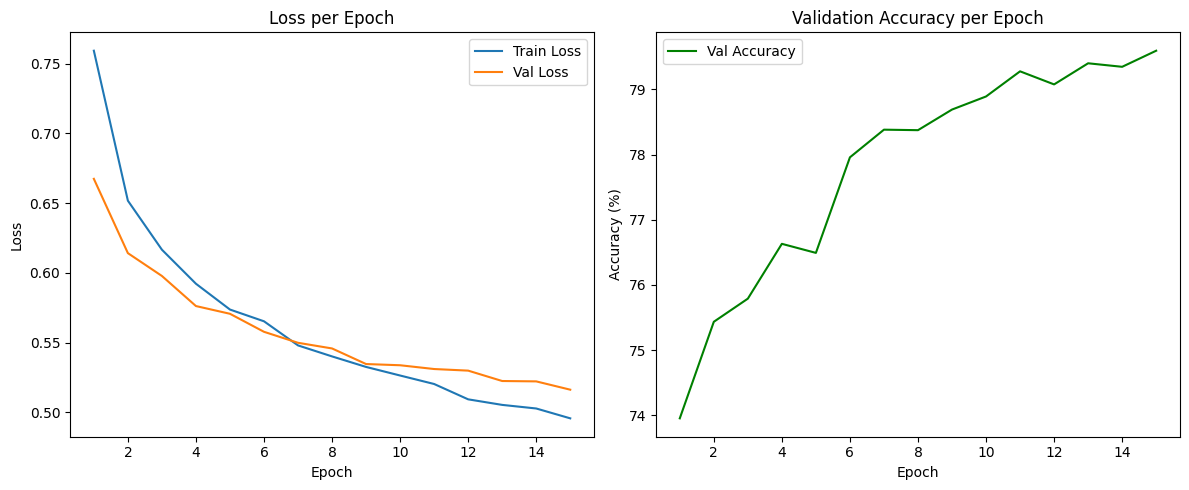

In [72]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=15,
    patience=3,
    checkpoint_path='best_stress_model.pt'
)

trainer.train()

<ipython-input-71-4f6095dd000e>:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_path, map_location=self.device)


Loaded checkpoint from best_stress_model.pt. Resuming from epoch 16.
Starting training at epoch 16 out of 23

Epoch 16/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.23it/s]


Train Loss: 0.4954 | Train Acc: 79.97%
Val Loss:   0.5147 | Val Acc:   79.95%
Validation loss improved: 0.5163 --> 0.5147. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 17/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 70.94it/s]


Train Loss: 0.4907 | Train Acc: 80.14%
Val Loss:   0.5061 | Val Acc:   80.39%
Validation loss improved: 0.5147 --> 0.5061. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 18/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.53it/s]


Train Loss: 0.4880 | Train Acc: 80.25%
Val Loss:   0.5054 | Val Acc:   80.05%
Validation loss improved: 0.5061 --> 0.5054. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 19/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.58it/s]


Train Loss: 0.4848 | Train Acc: 80.29%
Val Loss:   0.5113 | Val Acc:   79.78%
No improvement for 1 epochs...

Epoch 20/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 70.35it/s]


Train Loss: 0.4786 | Train Acc: 80.86%
Val Loss:   0.5069 | Val Acc:   80.15%
No improvement for 2 epochs...

Epoch 21/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 71.79it/s]


Train Loss: 0.4807 | Train Acc: 80.64%
Val Loss:   0.5032 | Val Acc:   80.29%
Validation loss improved: 0.5054 --> 0.5032. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 22/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.81it/s]


Train Loss: 0.4741 | Train Acc: 81.04%
Val Loss:   0.4977 | Val Acc:   80.82%
Validation loss improved: 0.5032 --> 0.4977. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 23/23


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.49it/s]


Train Loss: 0.4726 | Train Acc: 80.87%
Val Loss:   0.5028 | Val Acc:   80.31%
No improvement for 1 epochs...

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 23.
Training plots saved to training_plot.png


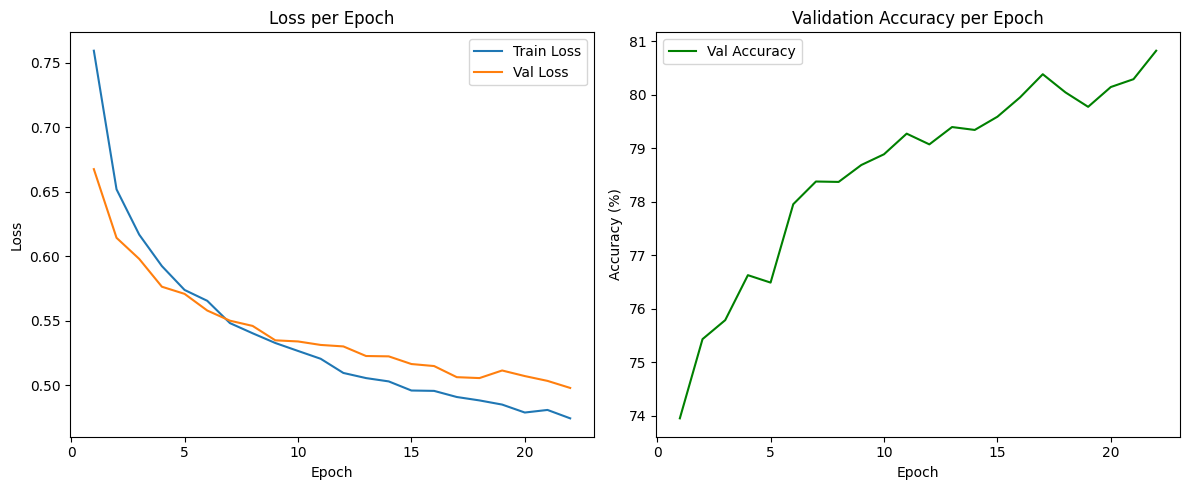

In [73]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=8,
    patience=3,
    checkpoint_path='best_stress_model.pt',
    resume=True
)

trainer.train()

<ipython-input-71-4f6095dd000e>:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_path, map_location=self.device)


Loaded checkpoint from best_stress_model.pt. Resuming from epoch 23.
Starting training at epoch 23 out of 27

Epoch 23/27


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.24it/s]


Train Loss: 0.4704 | Train Acc: 80.93%
Val Loss:   0.5006 | Val Acc:   80.78%
No improvement for 1 epochs...

Epoch 24/27


Validate: 100%|██████████| 406/406 [00:05<00:00, 72.96it/s]


Train Loss: 0.4706 | Train Acc: 81.03%
Val Loss:   0.4989 | Val Acc:   80.33%
No improvement for 2 epochs...

Epoch 25/27


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.47it/s]


Train Loss: 0.4651 | Train Acc: 81.28%
Val Loss:   0.4917 | Val Acc:   81.01%
Validation loss improved: 0.4977 --> 0.4917. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 26/27


Validate: 100%|██████████| 406/406 [00:05<00:00, 74.69it/s]


Train Loss: 0.4659 | Train Acc: 81.18%
Val Loss:   0.4934 | Val Acc:   80.58%
No improvement for 1 epochs...

Epoch 27/27


Validate: 100%|██████████| 406/406 [00:05<00:00, 73.43it/s]


Train Loss: 0.4649 | Train Acc: 81.15%
Val Loss:   0.4973 | Val Acc:   80.77%
No improvement for 2 epochs...

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 26.
Training plots saved to training_plot.png


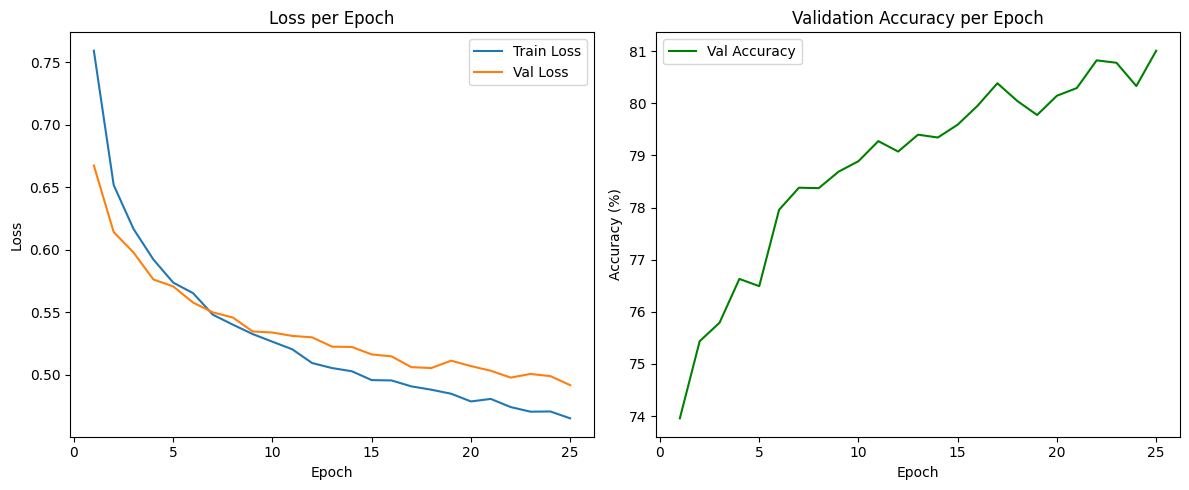

In [75]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=5,
    patience=3,
    checkpoint_path='best_stress_model.pt',
    resume=True
)

trainer.train()

In [ ]:
@torch.no_grad()
def validate_with_calibration(trainer, val_loader):
    trainer.model.eval()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_confidences = []
    all_corrects = []

    for (padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos), stress_labels in tqdm(val_loader, desc='Validate'):

        padded_word_tensors = padded_word_tensors.to(trainer.device)
        padded_vowel_masks = padded_vowel_masks.to(trainer.device)
        lengths = lengths.to(trainer.device)
        norm_char_pos = norm_char_pos.to(trainer.device)
        norm_vowel_pos = norm_vowel_pos.to(trainer.device)
        stress_labels = stress_labels.to(trainer.device)

        logits_list = trainer.model((padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos))

        losses = []
        correct_preds = 0

        for i in range(len(logits_list)):
            logits = logits_list[i]
            target = stress_labels[i] - 1

            loss = F.cross_entropy(logits.unsqueeze(0), target.unsqueeze(0))
            losses.append(loss)

            probs = F.softmax(logits, dim=0)
            max_prob, pred_idx = torch.max(probs, dim=0)
            correct = (pred_idx.item() == target.item())

            all_confidences.append(max_prob.item())
            all_corrects.append(int(correct))

            if correct:
                correct_preds += 1

        if len(losses) == 0:
            continue

        batch_loss = torch.stack(losses).mean()

        total_loss += batch_loss.item() * len(logits_list)
        total_correct += correct_preds
        total_samples += len(logits_list)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0

    print(f"Validation Loss: {avg_loss:.4f} | Validation Accuracy: {accuracy:.2f}%")

    return all_confidences, all_corrects

Validate: 100%|██████████| 406/406 [00:05<00:00, 68.18it/s]


Validation Loss: 0.4917 | Validation Accuracy: 81.01%


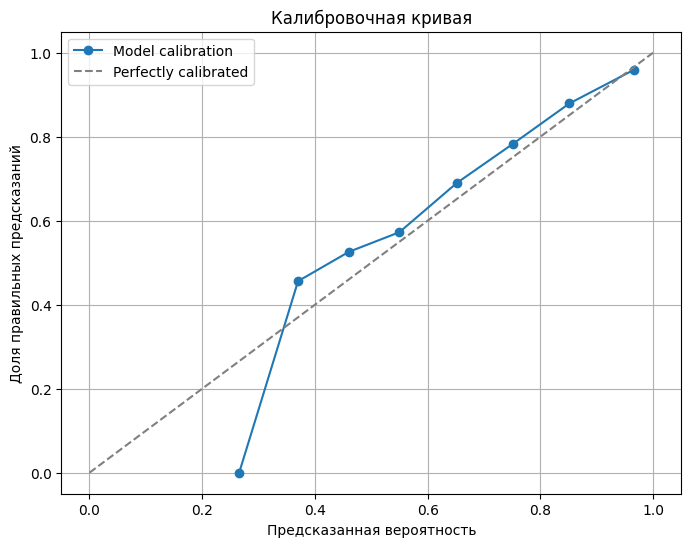

In [77]:
confidences, corrects = validate_with_calibration(trainer, val_loader)

prob_true, prob_pred = calibration_curve(corrects, confidences, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля правильных предсказаний')
plt.title('Калибровочная кривая')
plt.legend()
plt.grid(True)
plt.show()

#### Аналогичный эксперимент для LSTM

In [89]:
class StressLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, dropout=0.3):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.input_features_dim = embedding_dim + 3

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size + 1,
            embedding_dim=embedding_dim,
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            input_size=self.input_features_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, inputs):
        padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos = inputs

        x_embed = self.embedding(padded_word_tensors)

        vowel_mask_expanded = padded_vowel_masks.unsqueeze(-1)
        norm_char_pos_expanded = norm_char_pos.unsqueeze(-1)
        norm_vowel_pos_expanded = norm_vowel_pos.unsqueeze(-1)

        x = torch.cat([x_embed, vowel_mask_expanded, norm_char_pos_expanded, norm_vowel_pos_expanded], dim=-1)

        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        packed_output, _ = self.lstm(packed_input)

        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dropout(output)

        logits_list = []
        for i in range(output.size(0)):
            mask = padded_vowel_masks[i].bool()
            output_vowels_only = output[i][mask]

            logits_vowels = self.fc(output_vowels_only).squeeze(-1)
            logits_list.append(logits_vowels)

        return logits_list

model = StressLSTM(vocab_size=vocab_size)

Starting fresh training with model StressLSTM
Starting training at epoch 1 out of 10

Epoch 1/10


Validate: 100%|██████████| 406/406 [00:06<00:00, 67.37it/s]


Train Loss: 0.6124 | Train Acc: 74.44%
Val Loss:   0.5613 | Val Acc:   77.53%
Validation loss improved: inf --> 0.5613. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 2/10


Validate: 100%|██████████| 406/406 [00:05<00:00, 67.87it/s]


Train Loss: 0.4430 | Train Acc: 82.00%
Val Loss:   0.5198 | Val Acc:   80.08%
Validation loss improved: 0.5613 --> 0.5198. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 3/10


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.34it/s]


Train Loss: 0.3473 | Train Acc: 86.38%
Val Loss:   0.4809 | Val Acc:   81.53%
Validation loss improved: 0.5198 --> 0.4809. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 4/10


Validate: 100%|██████████| 406/406 [00:05<00:00, 75.80it/s]


Train Loss: 0.2780 | Train Acc: 89.24%
Val Loss:   0.5091 | Val Acc:   81.91%
No improvement for 1 epochs...

Epoch 5/10


Validate: 100%|██████████| 406/406 [00:06<00:00, 67.55it/s]


Train Loss: 0.2297 | Train Acc: 91.41%
Val Loss:   0.5436 | Val Acc:   81.82%
No improvement for 2 epochs...

Epoch 6/10


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.01it/s]
<ipython-input-71-4f6095dd000e>:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.c

Train Loss: 0.1913 | Train Acc: 92.77%
Val Loss:   0.5525 | Val Acc:   81.99%
No improvement for 3 epochs...

Early stopping triggered. Loading best checkpoint...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 4.

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 4.
Training plots saved to training_plot.png


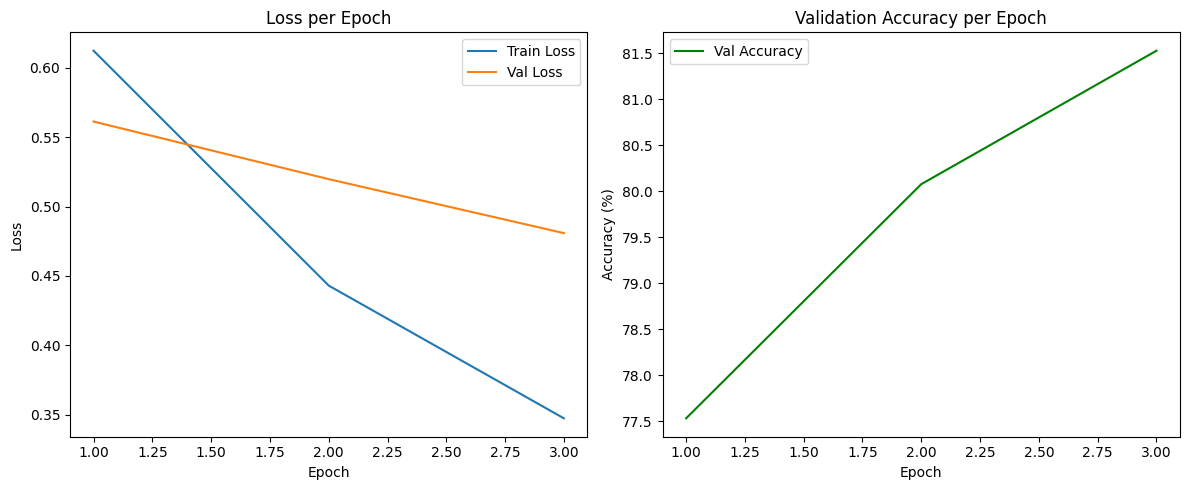

In [90]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=10,
    patience=3,
    checkpoint_path='best_stress_model.pt'
)

trainer.train()

Validate: 100%|██████████| 406/406 [00:06<00:00, 64.36it/s]


Validation Loss: 0.4809 | Validation Accuracy: 81.53%


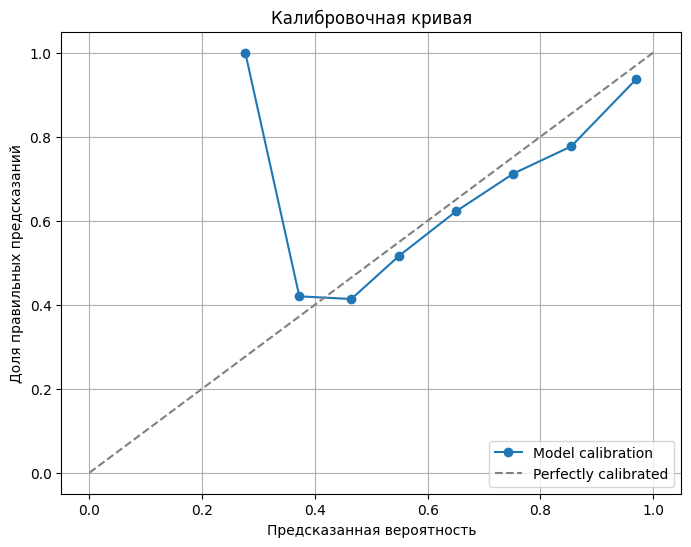

In [91]:
confidences, corrects = validate_with_calibration(trainer, val_loader)

prob_true, prob_pred = calibration_curve(corrects, confidences, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля правильных предсказаний')
plt.title('Калибровочная кривая')
plt.legend()
plt.grid(True)
plt.show()

Дополнительные признаки не дали почти никакого прироста, но получилось улучшить качество путём увеличения количества эпох в случае CNN и увеличением размера эмбеддингов и скрытого слоя в случае LSTM. 

## Трансформер

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [batch_size, seq_len, d_model]
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

In [ ]:
class StressTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim=125, n_heads=8, hidden_dim=256, num_layers=4, dropout=0.3):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.additional_features_dim = 3
        self.total_input_dim = embedding_dim + self.additional_features_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size + 1,
            embedding_dim=embedding_dim,
            padding_idx=0
        )

        self.positional_encoding = PositionalEncoding(self.total_input_dim, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.total_input_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(self.total_input_dim, 1)

    def forward(self, inputs):
        padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos = inputs

        x_embed = self.embedding(padded_word_tensors)

        vowel_mask_expanded = padded_vowel_masks.unsqueeze(-1)
        norm_char_pos_expanded = norm_char_pos.unsqueeze(-1)
        norm_vowel_pos_expanded = norm_vowel_pos.unsqueeze(-1)
        x = torch.cat([x_embed, vowel_mask_expanded, norm_char_pos_expanded, norm_vowel_pos_expanded], dim=-1)

        x = self.positional_encoding(x)

        padding_mask = (padded_word_tensors == 0)

        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)

        logits = self.fc(x).squeeze(-1)

        logits_list = []
        for i in range(logits.size(0)):
            mask = padded_vowel_masks[i].bool()
            logits_vowels = logits[i][mask]
            logits_list.append(logits_vowels)

        return logits_list

model = StressTransformer(vocab_size=vocab_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Starting fresh training with model StressTransformer
Starting training at epoch 1 out of 20

Epoch 1/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 67.70it/s]


Train Loss: 0.9899 | Train Acc: 53.26%
Val Loss:   0.8286 | Val Acc:   64.49%
Validation loss improved: inf --> 0.8286. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 2/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.90it/s]


Train Loss: 0.8588 | Train Acc: 61.73%
Val Loss:   0.7856 | Val Acc:   67.73%
Validation loss improved: 0.8286 --> 0.7856. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 3/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 70.16it/s]


Train Loss: 0.8137 | Train Acc: 64.31%
Val Loss:   0.7283 | Val Acc:   68.79%
Validation loss improved: 0.7856 --> 0.7283. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 4/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.73it/s]


Train Loss: 0.7801 | Train Acc: 66.40%
Val Loss:   0.7316 | Val Acc:   70.02%
No improvement for 1 epochs...

Epoch 5/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.79it/s]


Train Loss: 0.7582 | Train Acc: 67.54%
Val Loss:   0.6923 | Val Acc:   71.06%
Validation loss improved: 0.7283 --> 0.6923. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 6/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.78it/s]


Train Loss: 0.7431 | Train Acc: 67.93%
Val Loss:   0.7125 | Val Acc:   70.79%
No improvement for 1 epochs...

Epoch 7/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.98it/s]


Train Loss: 0.7284 | Train Acc: 68.71%
Val Loss:   0.6909 | Val Acc:   71.33%
Validation loss improved: 0.6923 --> 0.6909. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 8/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.59it/s]


Train Loss: 0.7144 | Train Acc: 69.62%
Val Loss:   0.6821 | Val Acc:   72.02%
Validation loss improved: 0.6909 --> 0.6821. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 9/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.27it/s]


Train Loss: 0.7126 | Train Acc: 69.47%
Val Loss:   0.6757 | Val Acc:   72.20%
Validation loss improved: 0.6821 --> 0.6757. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 10/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.99it/s]


Train Loss: 0.7097 | Train Acc: 69.56%
Val Loss:   0.6728 | Val Acc:   72.31%
Validation loss improved: 0.6757 --> 0.6728. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 11/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 78.12it/s]


Train Loss: 0.7083 | Train Acc: 69.78%
Val Loss:   0.6728 | Val Acc:   72.31%
Validation loss improved: 0.6728 --> 0.6728. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 12/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.48it/s]


Train Loss: 0.7063 | Train Acc: 69.79%
Val Loss:   0.6750 | Val Acc:   72.31%
No improvement for 1 epochs...

Epoch 13/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 70.59it/s]


Train Loss: 0.7069 | Train Acc: 69.72%
Val Loss:   0.6683 | Val Acc:   72.56%
Validation loss improved: 0.6728 --> 0.6683. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 14/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.65it/s]


Train Loss: 0.7046 | Train Acc: 69.79%
Val Loss:   0.6683 | Val Acc:   72.62%
No improvement for 1 epochs...

Epoch 15/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.23it/s]


Train Loss: 0.7029 | Train Acc: 69.92%
Val Loss:   0.6626 | Val Acc:   72.92%
Validation loss improved: 0.6683 --> 0.6626. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 16/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 76.62it/s]


Train Loss: 0.7025 | Train Acc: 69.60%
Val Loss:   0.6579 | Val Acc:   72.81%
Validation loss improved: 0.6626 --> 0.6579. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 17/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 77.29it/s]


Train Loss: 0.6942 | Train Acc: 70.13%
Val Loss:   0.6561 | Val Acc:   73.18%
Validation loss improved: 0.6579 --> 0.6561. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 18/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 69.59it/s]


Train Loss: 0.6898 | Train Acc: 70.47%
Val Loss:   0.6653 | Val Acc:   73.55%
No improvement for 1 epochs...

Epoch 19/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 68.63it/s]


Train Loss: 0.6851 | Train Acc: 70.91%
Val Loss:   0.6357 | Val Acc:   74.01%
Validation loss improved: 0.6561 --> 0.6357. Saving checkpoint.
Saved new best model to best_stress_model.pt

Epoch 20/20


Validate: 100%|██████████| 406/406 [00:05<00:00, 67.69it/s]
<ipython-input-102-0e92ad4ca55c>:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Train Loss: 0.6773 | Train Acc: 70.96%
Val Loss:   0.6349 | Val Acc:   74.16%
Validation loss improved: 0.6357 --> 0.6349. Saving checkpoint.
Saved new best model to best_stress_model.pt

Training finished. Loading best model...
Loaded checkpoint from best_stress_model.pt. Resuming from epoch 21.
Training plots saved to training_plot.png


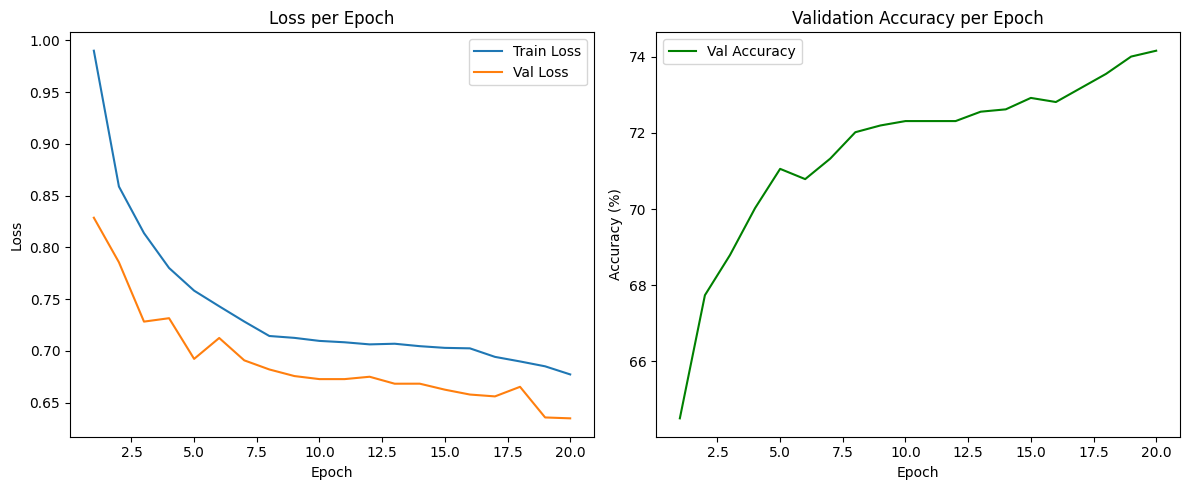

In [107]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    lr=1e-3,
    epochs=20,
    patience=3,
    checkpoint_path='best_stress_model.pt',
    optimizer=optimizer,
    scheduler=scheduler
)

trainer.train()

Таким образом, видим, что LSTM показала наилучший результат.

Что следует улучшить в будущем: векторизировать вычисления, поэксперементировать со структурой используемых моделей и параметрами.

# Предсказываем для test.csv

Без дополнительных признаков

In [ ]:
def inference_and_save(trainer, test_loader, submission_path='/kaggle/working/submission.csv'):
    trainer.model.eval()
    predictions = []
    ids = []

    with torch.no_grad():
        for (padded_word_tensors, padded_vowel_masks, lengths), batch_ids in tqdm(test_loader, desc='Inferencing'):
            padded_word_tensors = padded_word_tensors.to(trainer.device)
            padded_vowel_masks = padded_vowel_masks.to(trainer.device)
            lengths = lengths.to(trainer.device)

            # список логитов по гласным
            logits_list = trainer.model((padded_word_tensors, padded_vowel_masks, lengths))

            batch_size = len(logits_list)

            for i in range(batch_size):
                logits_vowels = logits_list[i]

                pred_vowel_index = logits_vowels.argmax().item()
                stress_syllable = pred_vowel_index + 1      # 1-based номер слога

                predictions.append(stress_syllable)
                ids.append(batch_ids[i])

    submission_df = pd.DataFrame({
        'id': ids,
        'stress': predictions
    })

    submission_df.sort_values('id', inplace=True)
    submission_df.reset_index(drop=True, inplace=True)

    submission_df.to_csv(submission_path, index=False)
    print(f"Submission saved to {submission_path}")

In [81]:
inference_and_save(trainer, test_loader, submission_path='submission.csv')

Inferencing: 100%|██████████| 937/937 [00:11<00:00, 78.10it/s]


 Submission saved to submission.csv


С дополнительными признаками

In [ ]:
def inference_and_save_2(trainer, test_loader, submission_path='/kaggle/working/submission.csv'):
    trainer.model.eval()
    predictions = []
    ids = []

    with torch.no_grad():
        for (padded_word_tensors, padded_vowel_masks, lengths, norm_char_pos, norm_vowel_pos), batch_ids in tqdm(test_loader, desc='Inferencing'):

            padded_word_tensors = padded_word_tensors.to(trainer.device)
            padded_vowel_masks = padded_vowel_masks.to(trainer.device)
            lengths = lengths.to(trainer.device)
            norm_char_pos = norm_char_pos.to(trainer.device)
            norm_vowel_pos = norm_vowel_pos.to(trainer.device)

            logits_list = trainer.model((
                padded_word_tensors, 
                padded_vowel_masks, 
                lengths, 
                norm_char_pos, 
                norm_vowel_pos
            ))

            batch_size = len(logits_list)

            for i in range(batch_size):
                logits_vowels = logits_list[i]
                pred_vowel_index = logits_vowels.argmax().item()
                stress_syllable = pred_vowel_index + 1

                predictions.append(stress_syllable)
                ids.append(batch_ids[i])

    submission_df = pd.DataFrame({
        'id': ids,
        'stress': predictions
    })

    submission_df.sort_values('id', inplace=True)
    submission_df.reset_index(drop=True, inplace=True)

    submission_df.to_csv(submission_path, index=False)
    print(f" Submission saved to {submission_path}")

In [93]:
inference_and_save_2(trainer, test_loader, submission_path='submission.csv')

Inferencing: 100%|██████████| 937/937 [00:13<00:00, 72.00it/s]

 Submission saved to submission.csv


In [82]:
sub = pd.read_csv('/kaggle/working/submission.csv')
print(sub['stress'].unique())
sub.head(5)

[3 2 1 4 5 6]


,id,stress
0,0,3
1,1,3
2,2,3
3,3,2
4,4,1


In [31]:
sample = pd.read_csv('/kaggle/input/silero-stress-predictor/sample_submission.csv')
sample

,id,stress
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
29955,29955,1
29956,29956,1
29957,29957,1
29958,29958,1
